# DeepFake Detection - Explainable AI Analysis

This notebook demonstrates how to use the explainability tools to understand what features
allow the model to distinguish between real and AI-generated (fake) images.

## Overview

We analyze linear probing classifiers trained on:
- **DINOv2 embeddings**: Self-supervised vision transformer features
- **OpenCLIP embeddings**: Contrastive language-image pre-training features

The explainability analysis includes:
1. Feature importance analysis based on classifier coefficients
2. SHAP values for individual and global explanations
3. Embedding space visualization using PCA, t-SNE, and UMAP

In [ ]:
# Install dependencies if needed
# !pip install -r ../requirements.txt

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Import our explainability modules
from src.explainability import FeatureImportanceAnalyzer, SHAPExplainer, EmbeddingVisualizer
from src.utils import DataLoader, ReportGenerator

# Set style for plots
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        pass  # Use default style
%matplotlib inline

## 1. Load Data

First, we load the embeddings. You can either:
- Load your own embeddings from files
- Use synthetic data for demonstration

In [3]:
# Option 1: Load your own embeddings
data_loader = DataLoader()
data_loader.load_dinov2('DINOv2embeddings_and_labels.npz')
# data_loader.load_openclip('path/to/openclip_embeddings.npz')

# Option 2: Generate synthetic data for demonstration
""" 
data_loader = DataLoader()
data_loader.generate_synthetic_data(
    n_samples=10000,  # 5k real + 5k fake
    dinov2_dim=768,   # DINOv2 ViT-B/14 dimension
    openclip_dim=512  # OpenCLIP ViT-B/32 dimension
)
"""
# Print data summary
print("Data Summary:")
summary = data_loader.get_summary()
print(f"  DINOv2 embeddings shape: {summary['dinov2']['shape']}")
#print(f"  OpenCLIP embeddings shape: {summary['openclip']['shape']}")
print(f"  Labels: {summary['labels']['distribution']}")

Data Summary:
  DINOv2 embeddings shape: (10000, 384)
  Labels: {'real': 5000, 'fake': 5000}


In [4]:
# Split into train/test sets
splits = data_loader.train_test_split(test_size=0.2, random_state=42)

X_train_dinov2 = splits['dinov2_train']
X_test_dinov2 = splits['dinov2_test']
#X_train_openclip = splits['openclip_train']
#X_test_openclip = splits['openclip_test']
y_train = splits['labels_train']
y_test = splits['labels_test']

print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")

Training samples: 8000
Test samples: 2000


## 2. Feature Importance Analysis

We train a linear classifier and analyze which embedding dimensions are most important
for distinguishing real from fake images.

In [5]:
# Initialize and train the feature importance analyzer for DINOv2
dinov2_analyzer = FeatureImportanceAnalyzer()
dinov2_analyzer.fit_classifier(X_train_dinov2, y_train, normalize=True)

# Evaluate accuracy
y_pred = dinov2_analyzer.classifier.predict(dinov2_analyzer.scaler.transform(X_test_dinov2))
accuracy = accuracy_score(y_test, y_pred)
print(f"DINOv2 Linear Probing Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

DINOv2 Linear Probing Accuracy: 93.75%

Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.94      0.94      1000
        Fake       0.94      0.94      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



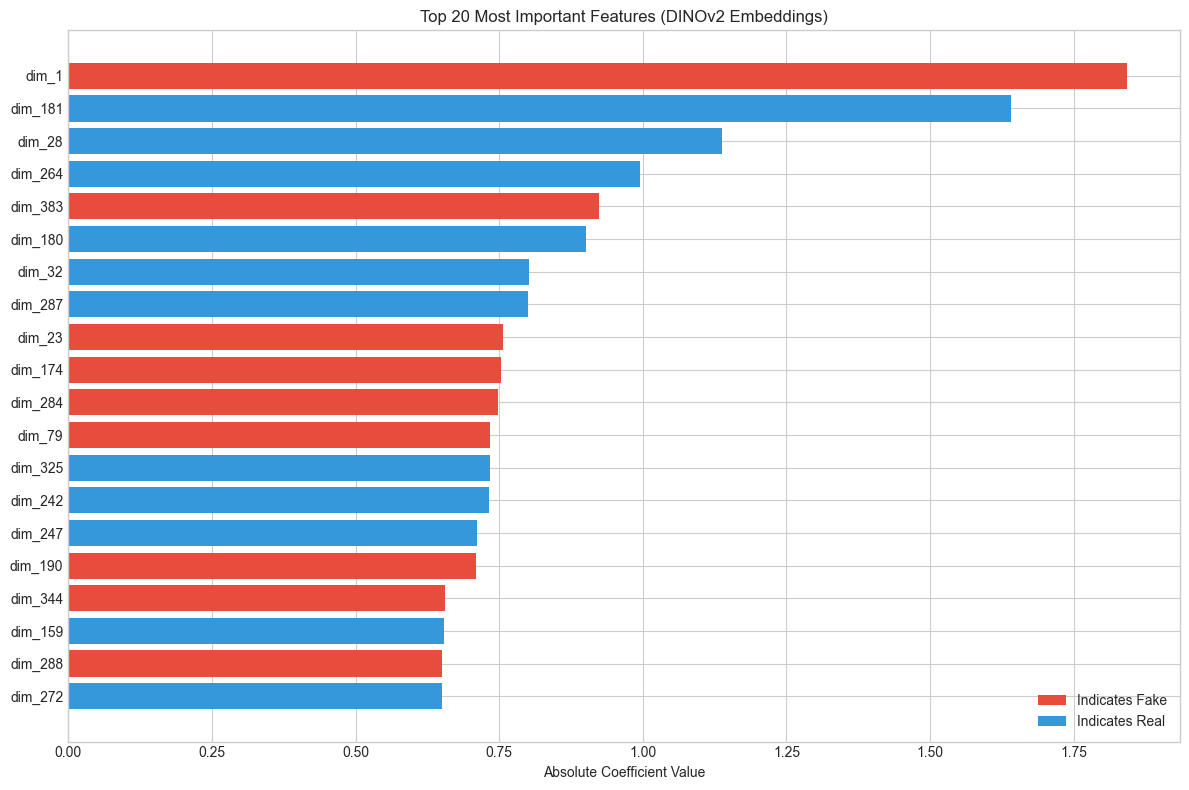

In [6]:
# Plot feature importance
fig = dinov2_analyzer.plot_feature_importance(
    top_k=20,
    title="Top 20 Most Important Features (DINOv2 Embeddings)"
)
plt.show()

In [7]:
# Analyze directional importance
directional = dinov2_analyzer.get_directional_importance()

print(f"Number of features indicating FAKE: {len(directional['fake_indicators'])}")
print(f"Number of features indicating REAL: {len(directional['real_indicators'])}")
print(f"\nTop 5 FAKE indicators: {directional['fake_indicators'][:5]}")
print(f"Top 5 REAL indicators: {directional['real_indicators'][:5]}")

Number of features indicating FAKE: 195
Number of features indicating REAL: 189

Top 5 FAKE indicators: [0 1 2 3 4]
Top 5 REAL indicators: [ 6  7  8 13 14]


In [8]:
# Analyze a single sample
sample_idx = 0
sample_embedding = X_test_dinov2[sample_idx]
sample_label = y_test[sample_idx]

analysis = dinov2_analyzer.analyze_embedding(sample_embedding, top_k=10)

print(f"True label: {'Fake' if sample_label == 1 else 'Real'}")
print(f"Prediction: {analysis['prediction']}")
print(f"Probability (Real): {analysis['probability_real']:.2%}")
print(f"Probability (Fake): {analysis['probability_fake']:.2%}")
print(f"\nTop contributing features:")
for feat, contrib, direction in zip(
    analysis['feature_names'][:5],
    analysis['top_contributions'][:5],
    analysis['contribution_direction'][:5]
):
    print(f"  {feat}: {contrib:.4f} (pushes toward {direction})")

True label: Real
Prediction: real
Probability (Real): 100.00%
Probability (Fake): 0.00%

Top contributing features:
  dim_1: -2.2933 (pushes toward real)
  dim_247: -1.5931 (pushes toward real)
  dim_325: 1.4376 (pushes toward fake)
  dim_383: -1.3460 (pushes toward real)
  dim_272: -1.2037 (pushes toward real)


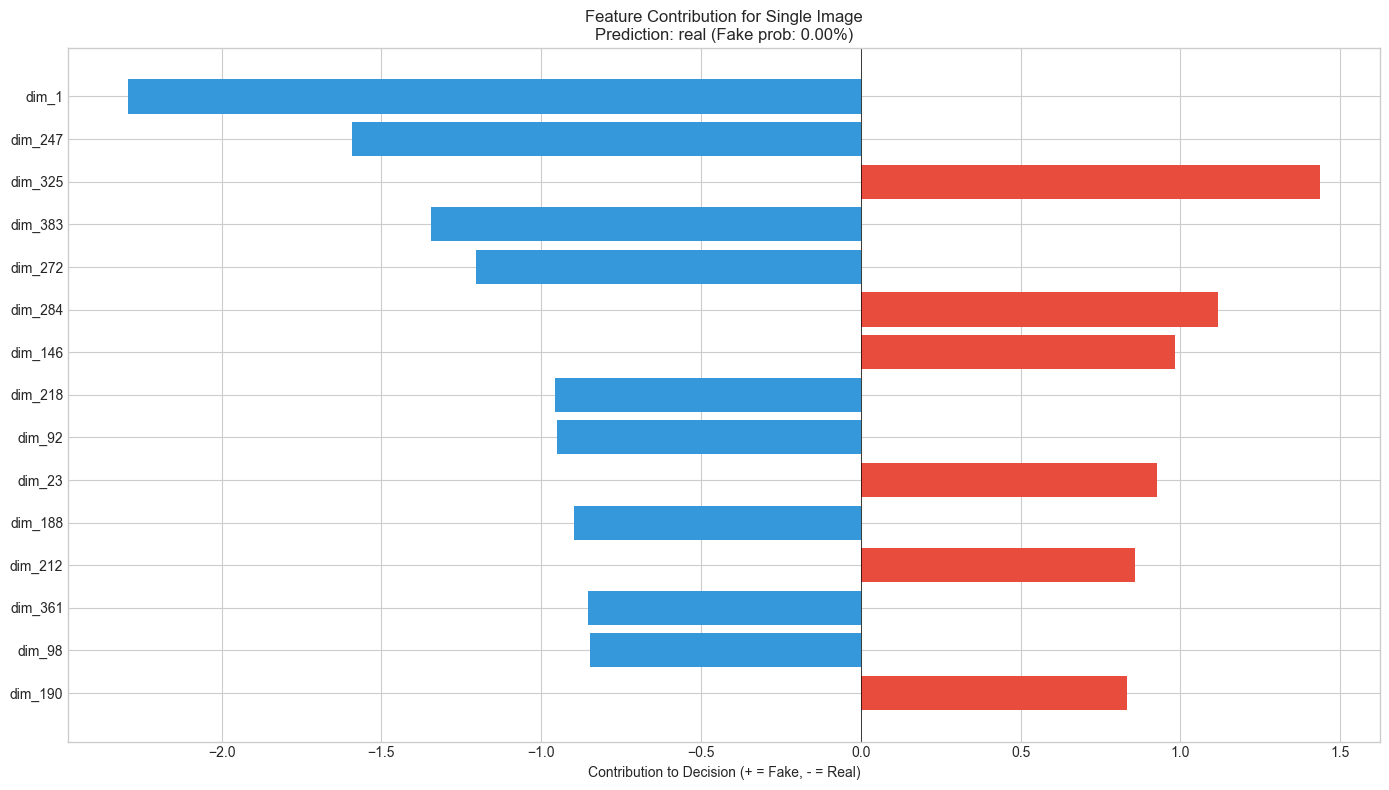

In [9]:
# Plot contribution breakdown for a single sample
fig = dinov2_analyzer.plot_contribution_breakdown(
    sample_embedding,
    top_k=15,
    title="Feature Contribution for Single Image"
)
plt.show()

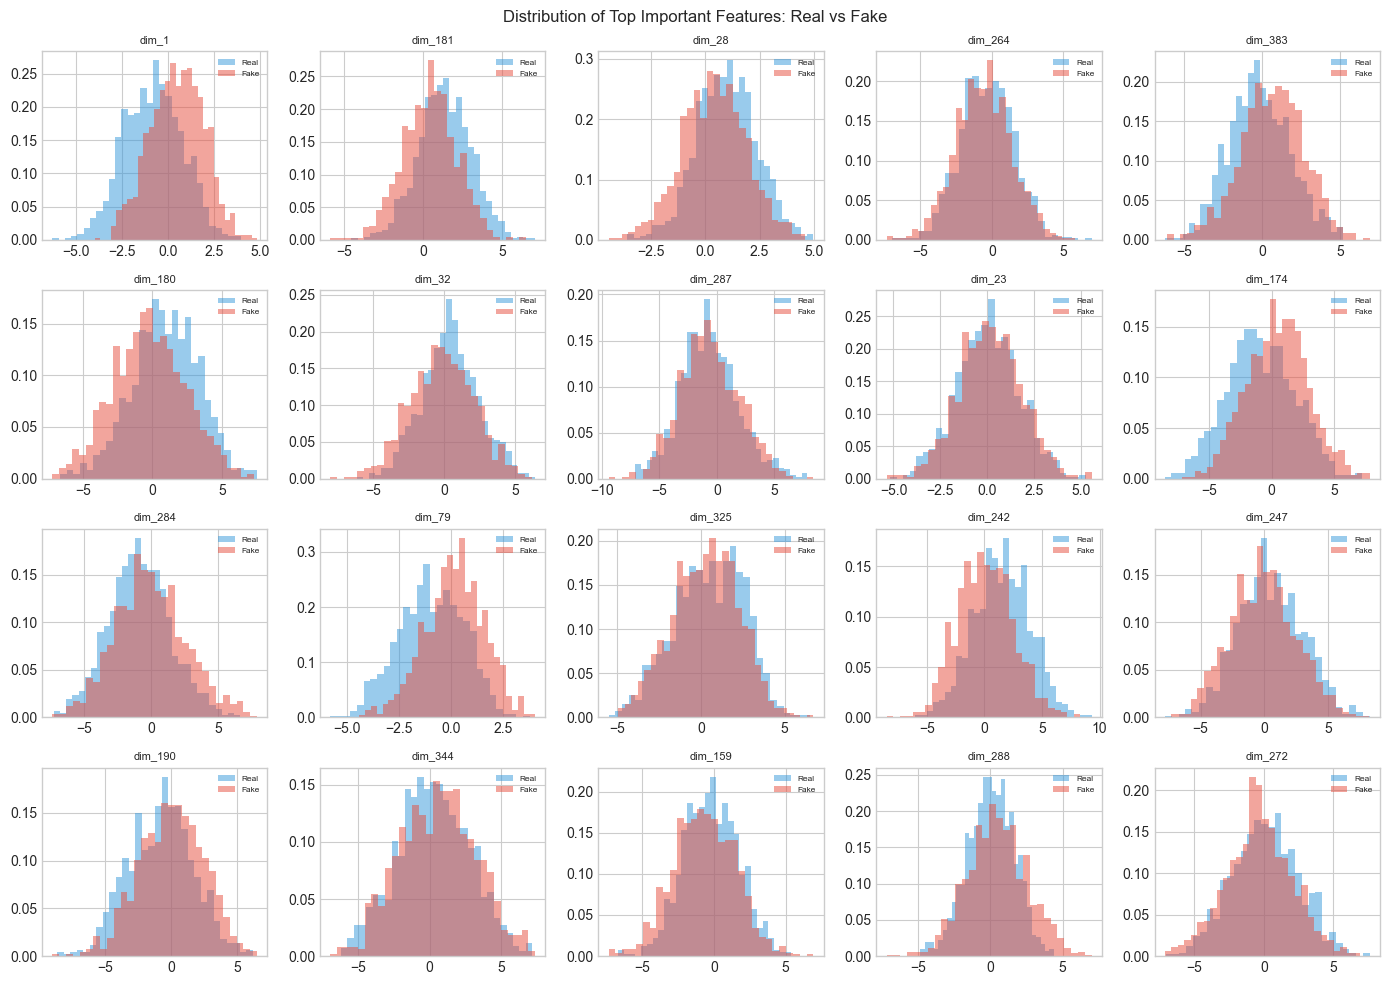

In [10]:
# Compare feature distributions between real and fake images
real_mask = y_test == 0
fake_mask = y_test == 1

fig = dinov2_analyzer.compare_embeddings(
    X_test_dinov2[real_mask],
    X_test_dinov2[fake_mask],
    top_k=20
)
plt.show()

## 3. SHAP Analysis

SHAP (SHapley Additive exPlanations) provides a unified measure of feature importance
based on game theory.

In [11]:
# Initialize SHAP explainer
# Note: We use scaled embeddings to match the classifier's input
X_train_scaled = dinov2_analyzer.scaler.transform(X_train_dinov2)

shap_explainer = SHAPExplainer(
    classifier=dinov2_analyzer.classifier,
    background_data=X_train_scaled,
    feature_names=dinov2_analyzer.feature_names
)

# Fit the explainer (using a subset of background data for efficiency)
shap_explainer.fit(n_background=100)
print("SHAP explainer fitted successfully!")

SHAP explainer fitted successfully!


C:\Users\ViVo\AppData\Roaming\Python\Python310\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [12]:
# Explain a single prediction
sample_scaled = dinov2_analyzer.scaler.transform(sample_embedding.reshape(1, -1))
explanation = shap_explainer.explain_single(sample_scaled, top_k=10)

print(f"Prediction: {explanation['prediction']}")
print(f"Base value: {explanation['base_value']:.4f}")
print(f"\nTop SHAP contributions:")
for feat, shap_val, direction in zip(
    explanation['top_feature_names'][:5],
    explanation['top_shap_values'][:5],
    explanation['feature_directions'][:5]
):
    print(f"  {feat}: {shap_val:.4f} (pushes toward {direction})")

Prediction: real
Base value: -0.6445

Top SHAP contributions:
  dim_1: -1.8873 (pushes toward real)
  dim_247: -1.7701 (pushes toward real)
  dim_325: 1.5345 (pushes toward fake)
  dim_383: -1.3637 (pushes toward real)
  dim_272: -1.2823 (pushes toward real)


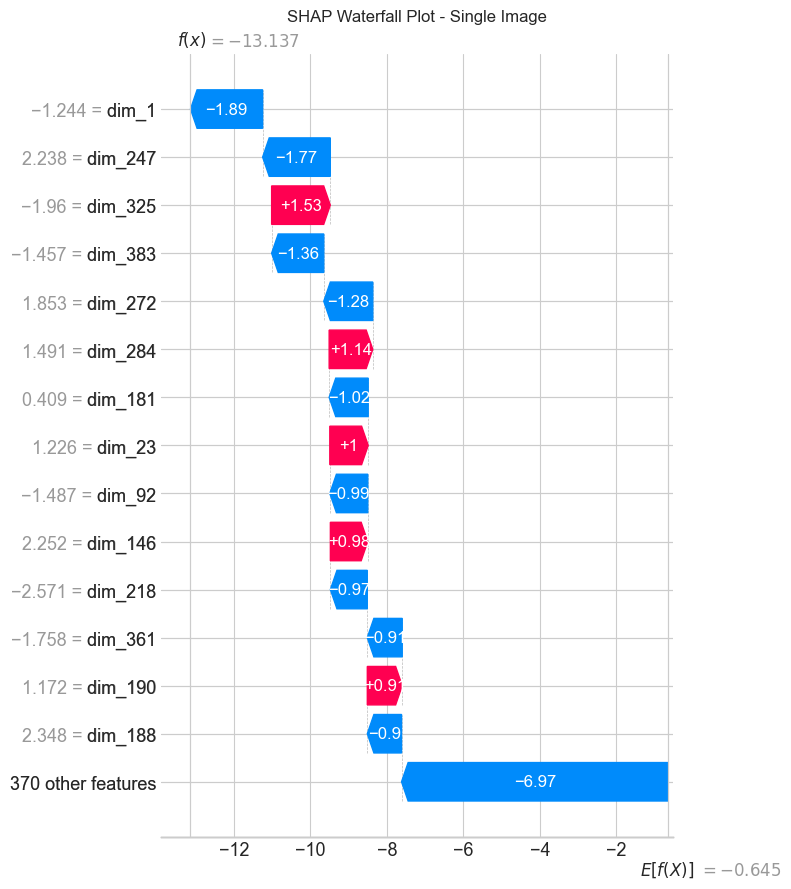

In [13]:
# SHAP waterfall plot for single prediction
fig = shap_explainer.plot_waterfall(sample_scaled, max_display=15, show=False)
plt.title("SHAP Waterfall Plot - Single Image")
plt.tight_layout()
plt.show()

In [14]:
# Global SHAP analysis on a subset of test data
X_test_scaled = dinov2_analyzer.scaler.transform(X_test_dinov2[:500])

global_importance = shap_explainer.get_global_importance(X_test_scaled)

print("Top 10 globally important features (by mean |SHAP|):")
for feat, imp in zip(
    global_importance['sorted_feature_names'][:10],
    global_importance['sorted_importance'][:10]
):
    print(f"  {feat}: {imp:.4f}")

Top 10 globally important features (by mean |SHAP|):
  dim_1: 1.6265
  dim_181: 1.3407
  dim_28: 0.9515
  dim_264: 0.8037
  dim_383: 0.7654
  dim_180: 0.7166
  dim_23: 0.6529
  dim_325: 0.6391
  dim_247: 0.6354
  dim_284: 0.6203


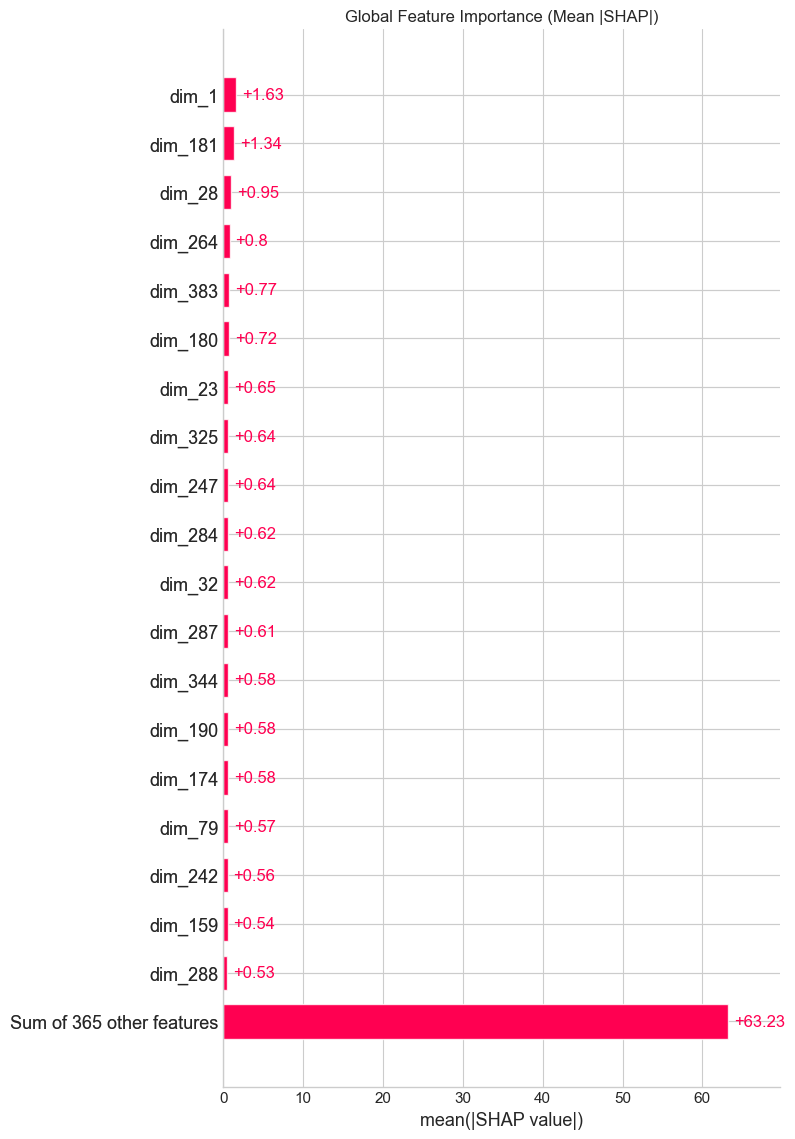

In [15]:
# SHAP bar plot
fig = shap_explainer.plot_bar(X_test_scaled, max_display=20, show=False)
plt.title("Global Feature Importance (Mean |SHAP|)")
plt.tight_layout()
plt.show()

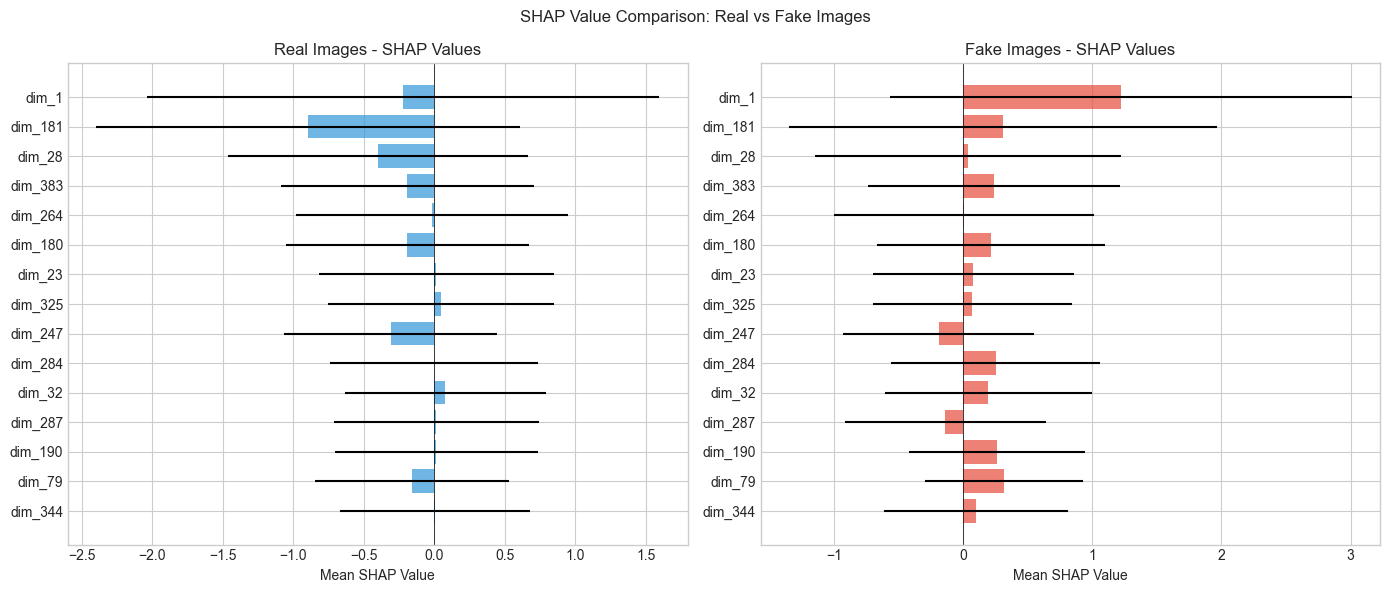

In [16]:
# Compare SHAP values for real vs fake images
real_scaled = dinov2_analyzer.scaler.transform(X_test_dinov2[real_mask][:200])
fake_scaled = dinov2_analyzer.scaler.transform(X_test_dinov2[fake_mask][:200])

fig = shap_explainer.compare_real_vs_fake(real_scaled, fake_scaled, top_k=15)
plt.show()

## 4. Embedding Space Visualization

We visualize the embedding space to understand how well the real and fake classes
are separated.

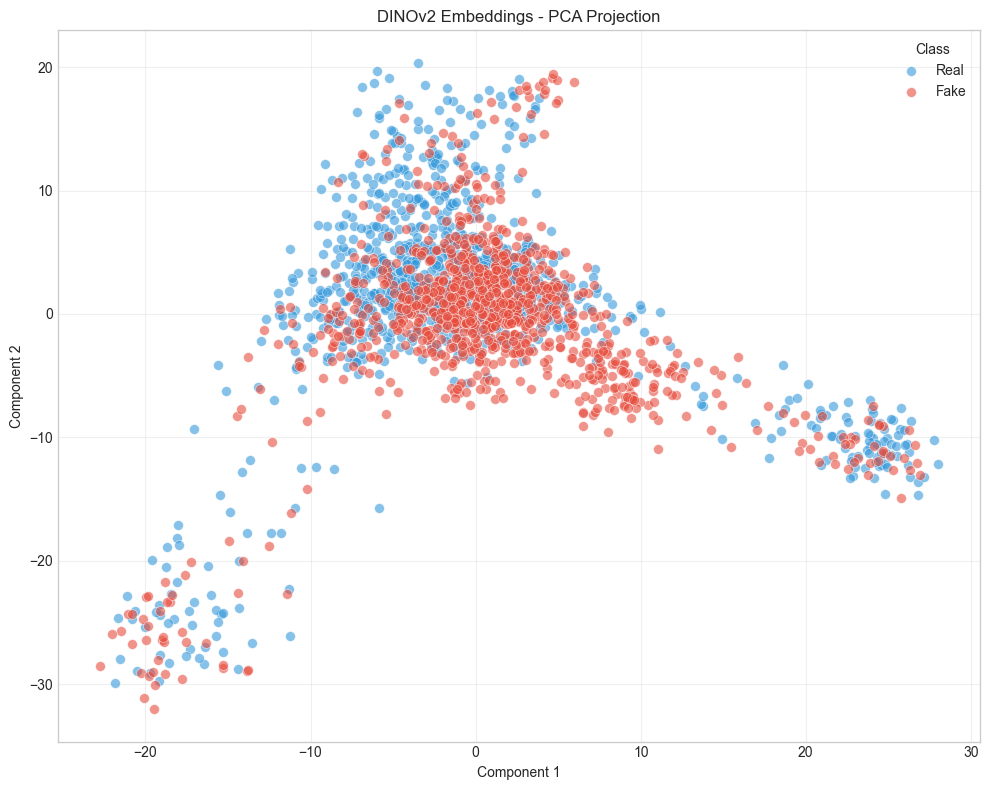

In [17]:
# Initialize visualizer with DINOv2 embeddings
visualizer = EmbeddingVisualizer(
    embeddings=X_test_dinov2,
    labels=y_test
)

# PCA visualization
visualizer.fit_pca(n_components=2)
fig = visualizer.plot_2d(title="DINOv2 Embeddings - PCA Projection")
plt.show()

In [18]:
# t-SNE visualization
visualizer.fit_tsne(n_components=2, perplexity=30)
fig = visualizer.plot_2d(title="DINOv2 Embeddings - t-SNE Projection")
plt.show()

TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

C:\Users\ViVo\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


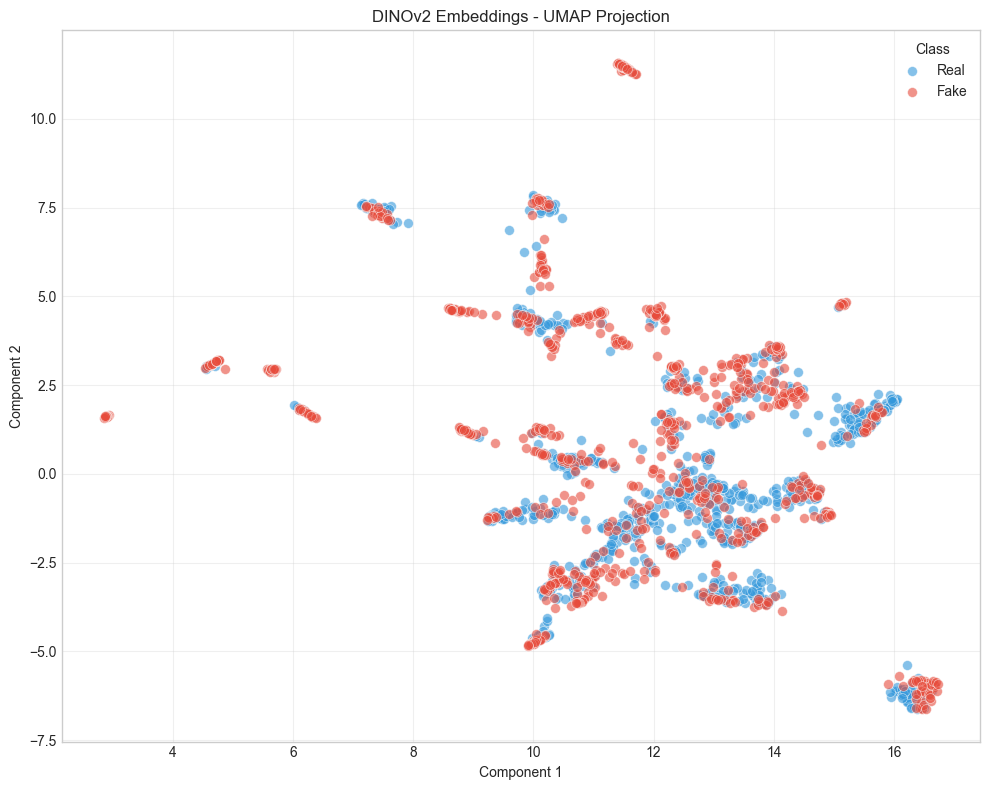

In [19]:
# UMAP visualization (if available)
try:
    visualizer.fit_umap(n_components=2, n_neighbors=15, min_dist=0.1)
    fig = visualizer.plot_2d(title="DINOv2 Embeddings - UMAP Projection")
    plt.show()
except ImportError:
    print("UMAP not installed. Install with: pip install umap-learn")

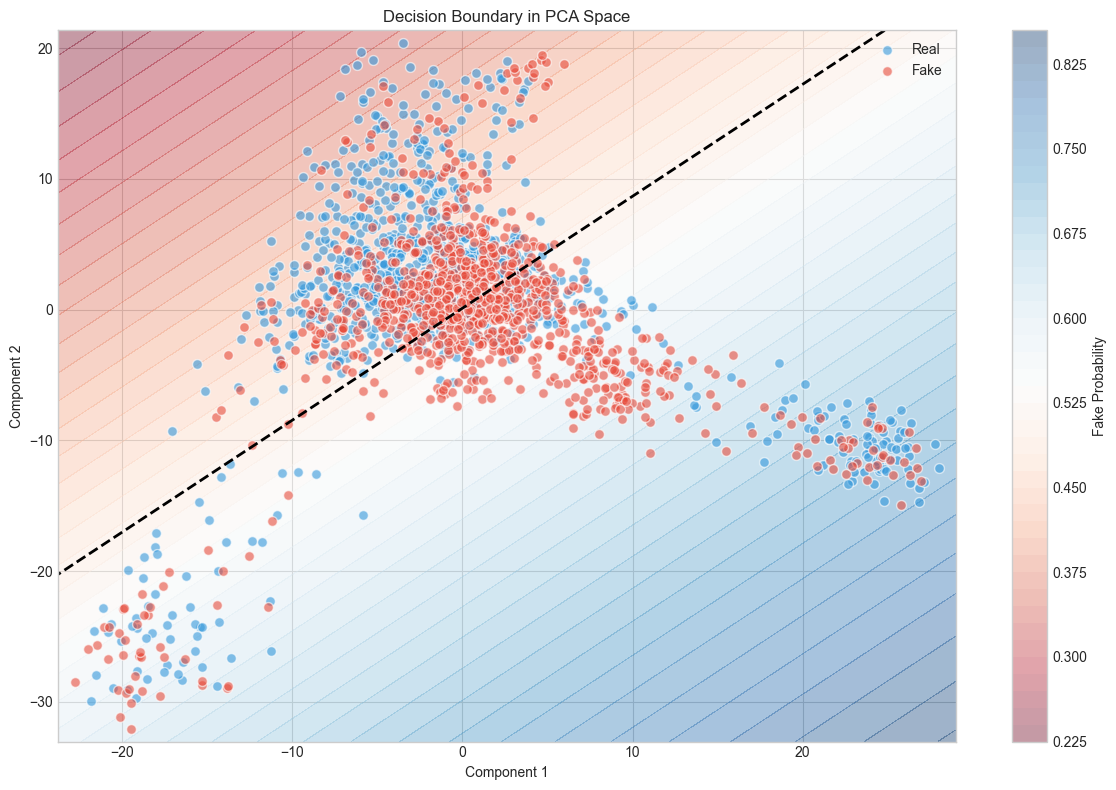

In [20]:
# Visualize decision boundary
visualizer.fit_pca(n_components=2)
fig = visualizer.plot_decision_boundary(
    dinov2_analyzer.classifier,
    title="Decision Boundary in PCA Space"
)
plt.show()

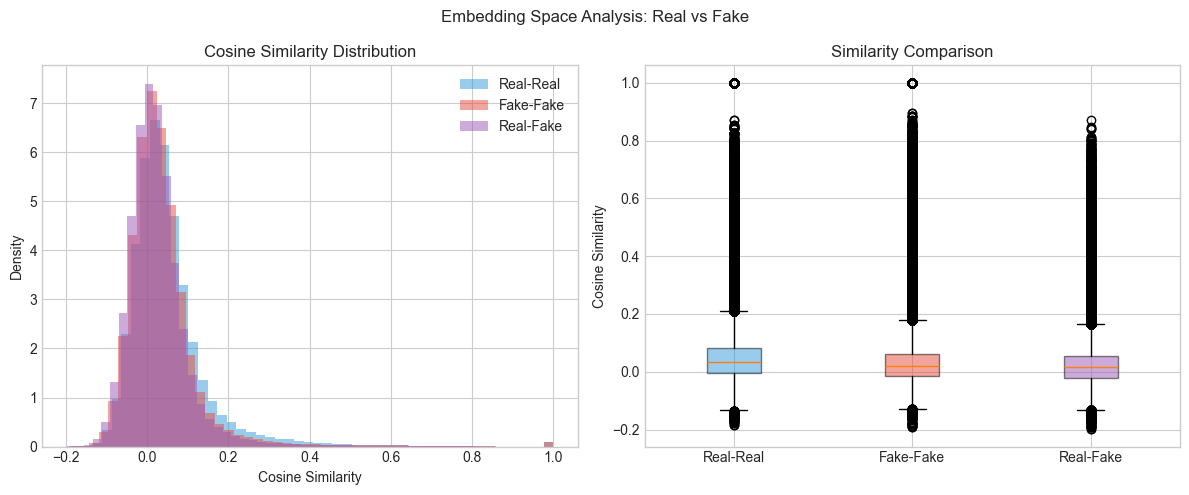

In [21]:
# Analyze embedding distances
fig = visualizer.plot_embedding_distances(n_samples=500)
plt.show()

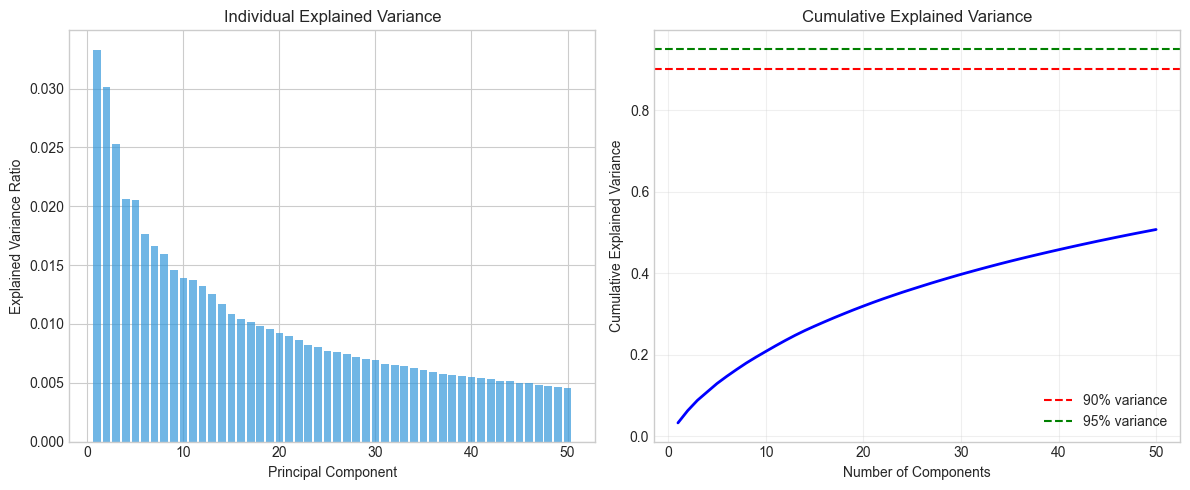

In [22]:
# PCA variance analysis
fig = visualizer.plot_pca_variance(n_components=50)
plt.show()

## 5. Compare DINOv2 vs OpenCLIP Embeddings

In [22]:
# Train classifier on OpenCLIP embeddings
openclip_analyzer = FeatureImportanceAnalyzer()
openclip_analyzer.fit_classifier(X_train_openclip, y_train, normalize=True)

y_pred_clip = openclip_analyzer.classifier.predict(openclip_analyzer.scaler.transform(X_test_openclip))
accuracy_clip = accuracy_score(y_test, y_pred_clip)

print(f"OpenCLIP Linear Probing Accuracy: {accuracy_clip:.2%}")

OpenCLIP Linear Probing Accuracy: 100.00%


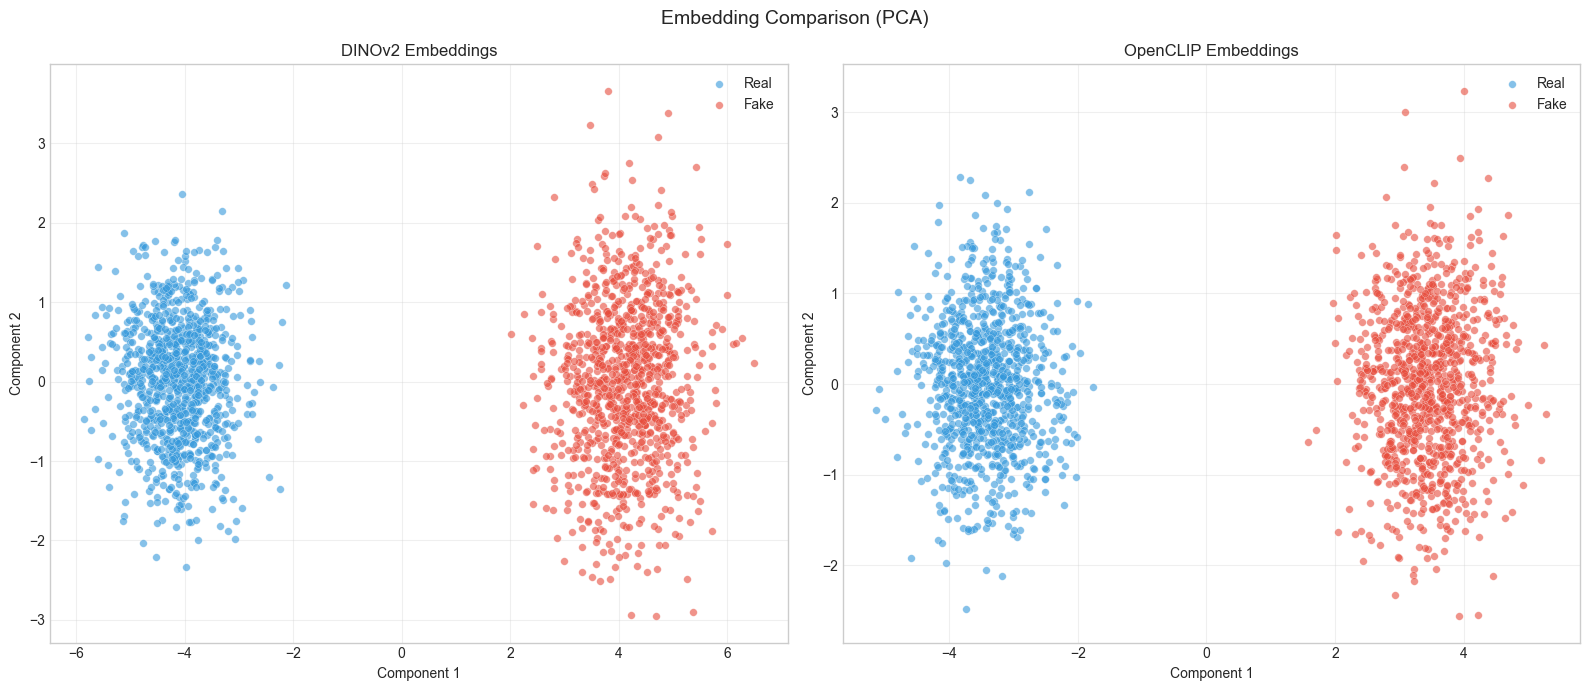

In [23]:
# Compare embedding spaces
dinov2_viz = EmbeddingVisualizer(embeddings=X_test_dinov2, labels=y_test)

fig = dinov2_viz.compare_embeddings(
    other_embeddings=X_test_openclip,
    other_labels=y_test,
    method='pca',
    titles=('DINOv2 Embeddings', 'OpenCLIP Embeddings')
)
plt.show()

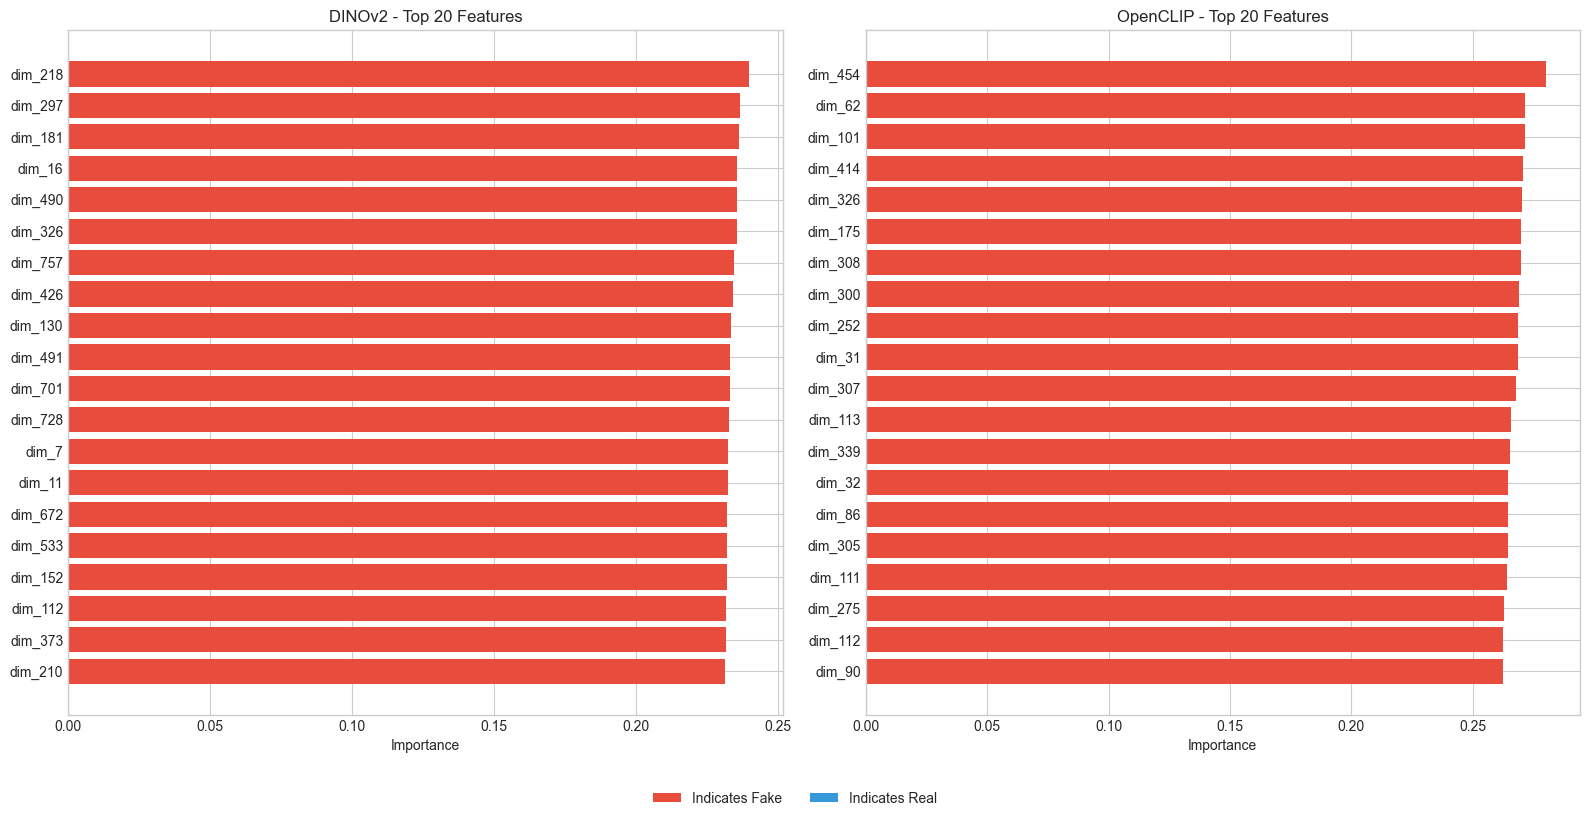

In [24]:
# Compare feature importance between the two models
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# DINOv2
imp_dinov2, idx_dinov2 = dinov2_analyzer.get_coefficient_importance()
coef_dinov2 = dinov2_analyzer.classifier.coef_.flatten()
top_20_dinov2 = idx_dinov2[:20]
colors_dinov2 = ['#e74c3c' if coef_dinov2[i] > 0 else '#3498db' for i in top_20_dinov2]

axes[0].barh(range(20), imp_dinov2[top_20_dinov2], color=colors_dinov2)
axes[0].set_yticks(range(20))
axes[0].set_yticklabels([f'dim_{i}' for i in top_20_dinov2])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance')
axes[0].set_title('DINOv2 - Top 20 Features')

# OpenCLIP
imp_openclip, idx_openclip = openclip_analyzer.get_coefficient_importance()
coef_openclip = openclip_analyzer.classifier.coef_.flatten()
top_20_openclip = idx_openclip[:20]
colors_openclip = ['#e74c3c' if coef_openclip[i] > 0 else '#3498db' for i in top_20_openclip]

axes[1].barh(range(20), imp_openclip[top_20_openclip], color=colors_openclip)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels([f'dim_{i}' for i in top_20_openclip])
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance')
axes[1].set_title('OpenCLIP - Top 20 Features')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Indicates Fake'),
    Patch(facecolor='#3498db', label='Indicates Real')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

## 6. Generate Report

In [24]:
# Generate a comprehensive report
report = ReportGenerator(model_name="DeepFake Detection with DINOv2 & OpenCLIP")

# Add model summary
report.add_model_summary(
    classifier=dinov2_analyzer.classifier,
    accuracy=accuracy,
    embedding_type="DINOv2",
    n_features=X_train_dinov2.shape[1],
    n_samples=len(y_train)
)

# Add feature importance
importance, sorted_idx = dinov2_analyzer.get_coefficient_importance()
top_10_idx = sorted_idx[:10]
coefs = dinov2_analyzer.classifier.coef_.flatten()

report.add_feature_importance_summary(
    top_features=[f'dim_{i}' for i in top_10_idx],
    top_importance=importance[top_10_idx].tolist(),
    directions=['fake' if coefs[i] > 0 else 'real' for i in top_10_idx]
)

# Add SHAP summary
report.add_shap_summary(global_importance['mean_abs_shap'], top_k=10)

# Add embedding analysis
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X_test_dinov2[:1000], y_test[:1000])
report.add_embedding_analysis(
    embedding_type="DINOv2",
    separation_score=accuracy,
    cluster_quality=silhouette
)

# Add conclusions
report.add_conclusion(
    key_findings=[
        f"DINOv2 linear probing achieves {accuracy:.1%} accuracy on DeepFake detection",
        f"Top discriminative features are concentrated in specific embedding dimensions",
        f"Both positive and negative feature contributions influence the decision"
    ],
    recommendations=[
        "Focus on the top discriminative dimensions for model optimization",
        "Consider ensemble methods combining DINOv2 and OpenCLIP",
        "Investigate samples near the decision boundary for potential improvements"
    ]
)

# Generate and display markdown report
markdown_report = report.generate_markdown()
print(markdown_report[:2000])  # Print first 2000 characters

# Explainable AI Report: DeepFake Detection with DINOv2 & OpenCLIP

**Generated**: 2025-12-05T12:28:04.894094

---


## Model Summary

| Metric | Value |
|--------|-------|
| Embedding Type | DINOv2 |
| Number of Features | 384 |
| Training Samples | 8000 |
| Accuracy | 93.75% |
| Classifier Type | LogisticRegression |

The model uses a linear classifier trained on pre-extracted embeddings to distinguish 
between real and AI-generated (fake) images.


---


## Feature Importance Analysis

The following features have the highest importance in distinguishing real from fake images:

| Feature | Importance | Indicates |
|---------|------------|-----------|
| dim_1 | 1.8428 | 🔴 Fake |
| dim_181 | 1.6402 | 🔵 Real |
| dim_28 | 1.1371 | 🔵 Real |
| dim_264 | 0.9954 | 🔵 Real |
| dim_383 | 0.9238 | 🔴 Fake |
| dim_180 | 0.9009 | 🔵 Real |
| dim_32 | 0.8025 | 🔵 Real |
| dim_287 | 0.8008 | 🔵 Real |
| dim_23 | 0.7558 | 🔴 Fake |
| dim_174 | 0.7529 | 🔴 Fake |

### Interpretation

- **🔴 Fake indicators**

In [27]:
# Save the report
# report.save('../reports/explainability_report.md', format='markdown')
report.save('../reports/explainability_report.json', format='json')
print("Report generation complete!")

Report generation complete!


## Summary

This notebook demonstrated how to:

1. **Feature Importance Analysis**: Identify which embedding dimensions are most discriminative
2. **SHAP Analysis**: Get game-theoretic explanations for individual predictions
3. **Embedding Visualization**: Understand the structure of the embedding space
4. **Model Comparison**: Compare DINOv2 and OpenCLIP embeddings
5. **Report Generation**: Create comprehensive reports for stakeholders

### Key Takeaways

- Linear probing on pre-trained embeddings is effective for DeepFake detection
- Feature importance reveals which embedding dimensions capture fake vs real distinctions
- SHAP values provide additive, interpretable explanations for each prediction
- Visualization helps understand class separation and potential edge cases